In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
%%time
#print('script started!',flush=True)
data = pd.read_csv('ISCX_Botnet_Labelled.csv')

CPU times: user 9.98 s, sys: 971 ms, total: 11 s
Wall time: 11.2 s


In [3]:
data.shape

(10000, 7638)

### Check class distribution .. is it balanced?

In [4]:
# Explore BotNet_Label values
s = data['BotNet_Label'].value_counts()

In [5]:
s

Normal                    4831
Weasel Bot                2220
Virut                     1370
Neris                      744
Murlo                      401
IRC                        150
Menti                      148
Zero access                 66
TBot                        27
Black hole 2                16
Zeus                        14
Black hole 3                 5
Sogou                        3
Weasel Botmaster             2
IRCbot and black hole1       2
Smoke bot                    1
Name: BotNet_Label, dtype: int64

In [6]:
# get a list of labels where the number of instances is > 10
labels = list(s[s > 10].index)

In [7]:
# remove BotNets where the number of instances is < 10
data = data[data['BotNet_Label'].isin(labels)]
data['BotNet_Label'].value_counts()

Normal          4831
Weasel Bot      2220
Virut           1370
Neris            744
Murlo            401
IRC              150
Menti            148
Zero access       66
TBot              27
Black hole 2      16
Zeus              14
Name: BotNet_Label, dtype: int64

In [8]:
#data.columns

### Missing value imputation

In [9]:
## FlowGenerator uses ? for a missing value .. let's replace it with NaN
data.replace('?', np.NaN,inplace=True)
print('symbol ? replaced with NaN',flush=True)
# using isnull() function  
data.isnull().values.any()

symbol ? replaced with NaN


False

In [10]:
data.isnull().sum().sum()

0

In [11]:
## Only run this code if your data contains NaNs
## Replace NaNs with the median of the column

for c in data.columns:
    if c != 'BotNet_Label':
        data[c] = pd.to_numeric(data[c], errors='coerce')
        data[c] = data[c].replace(np.NaN,data[c].median())
#save data so we can use it later
#data.to_csv('no_nans.csv',index=False)
#print('NaN values replaced with median in %f'%(t2-t1),flush=True)

### Plot Correlation Matrix to Check for Highly Correlated Features

In [12]:
## use all columns except protocol and ports to save time
tmp_df = data[['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s','Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 
'Flow IAT Min','Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min','Bwd IAT Mean',
'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min','Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min']]

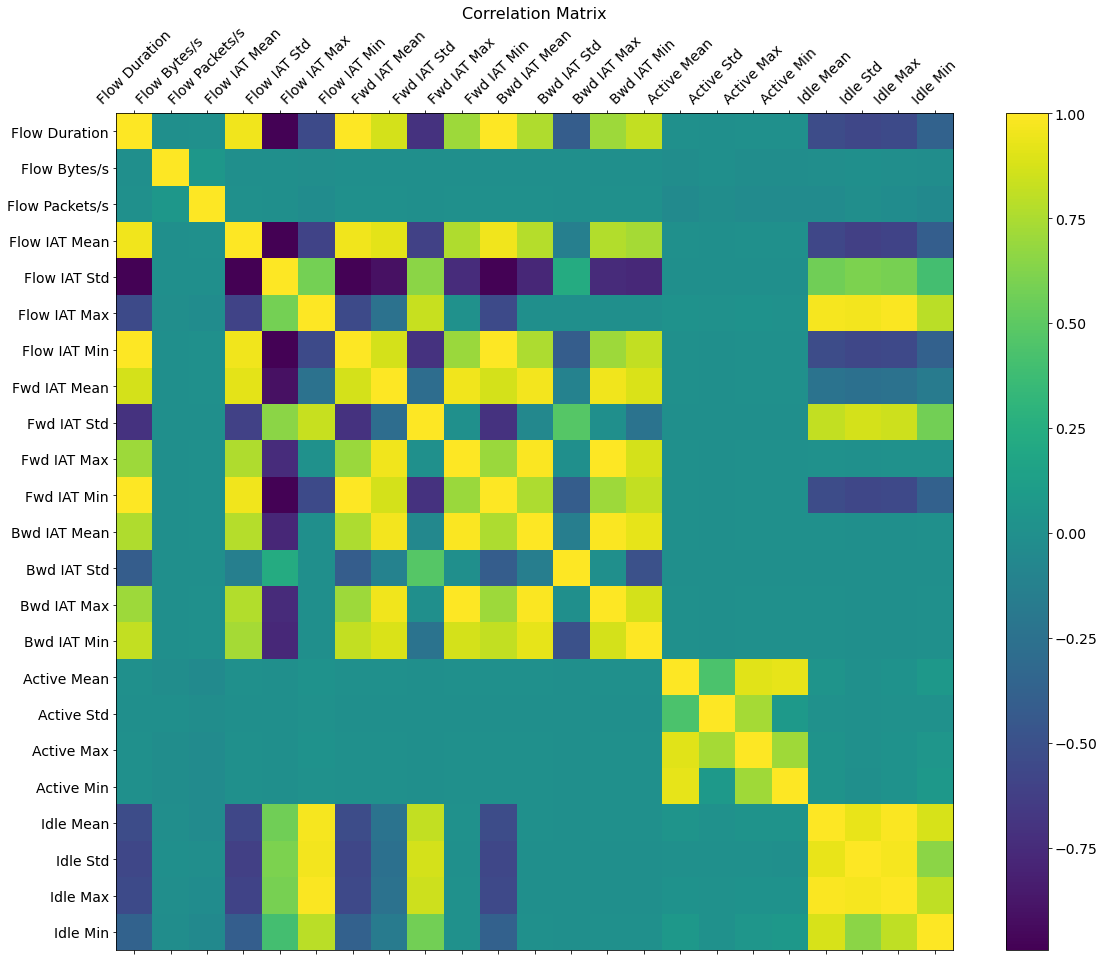

In [13]:
f = plt.figure(figsize=(19, 15))
plt.matshow(tmp_df.corr(), fignum=f.number)
plt.xticks(range(tmp_df.shape[1]), tmp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(tmp_df.shape[1]), tmp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

#### Do it Programmatically

In [14]:
# Create correlation matrix
corr_matrix = tmp_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Min',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Mean',
 'Bwd IAT Max',
 'Idle Mean',
 'Idle Std',
 'Idle Max']

#### Do you want to drop highly correlated features?

In [15]:
#remove highly correlated columns
data.drop(to_drop,axis=1, inplace=True)

In [16]:
data.columns

Index(['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Max',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Std', 'Bwd IAT Min',
       'Active Mean', 'Active Std',
       ...
       'DestPort_64452', 'DestPort_64470', 'DestPort_64775', 'DestPort_65432',
       'DestPort_65500', 'DestPort_65534', 'DestPort_65535', 'Protocol_0',
       'Protocol_6', 'Protocol_17'],
      dtype='object', length=7628)

In [17]:
%%time

Y = data['BotNet_Label']
data.drop('BotNet_Label', axis=1, inplace=True)

#remove single quote from column name
#rm_quote = lambda x: x.replace('\'', '')
#cols = data.columns
#data.columns = [rm_quote(x) for x in cols]

CPU times: user 89.9 ms, sys: 552 ms, total: 641 ms
Wall time: 641 ms


### Run Outlier Detection and Removal?

In [18]:
%%time
outliers_fraction = 0.5
rng = np.random.RandomState(42)

# fit the model
#clf = IsolationForest(contamination=outliers_fraction, random_state=rng, n_jobs=60)
#clf = EllipticEnvelope(contamination=outliers_fraction)
clf = LocalOutlierFactor(n_neighbors=25, contamination=outliers_fraction)
y_pred = clf.fit_predict(data)#only for LocalOutlierFactor


data['Outlier'] = y_pred
data['BotNet_Label'] = Y

outlier_mask = data['Outlier'].isin([-1])

print('To apply mask and removed outliters',flush=True)
data = data.loc[~outlier_mask]
data.drop('Outlier', axis=1, inplace=True)
print('data to be saved',flush=True)
#data.to_csv('no_outliers.csv',index=False)


To apply mask and removed outliters
data to be saved
CPU times: user 1min 24s, sys: 3.88 s, total: 1min 28s
Wall time: 1min 28s


In [19]:
data.shape

(4994, 7628)

In [22]:
#save subdatasets
labels = list(data['BotNet_Label'].unique())
for label in labels:
    tlbl = label.replace(" ", "_")#if label has space replace it with _
    tdata = data[data['BotNet_Label']==label]
    tdata.to_csv('Bot_'+tlbl+'.csv',index=False)
    print('Done: ',label,len(tdata))

print('all done', flush=True)

Done:  Normal 2110
Done:  Virut 621
Done:  Weasel Bot 1469
Done:  Murlo 304
Done:  Neris 284
Done:  IRC 88
Done:  Menti 84
Done:  TBot 11
Done:  Zero access 16
Done:  Zeus 6
Done:  Black hole 2 1
all done


In [23]:
data['BotNet_Label'].value_counts()

Normal          2110
Weasel Bot      1469
Virut            621
Murlo            304
Neris            284
IRC               88
Menti             84
Zero access       16
TBot              11
Zeus               6
Black hole 2       1
Name: BotNet_Label, dtype: int64

In [24]:
# Explore BotNet_Label values
s = data['BotNet_Label'].value_counts()

# get a list of labels where the number of instances is > 10
labels = list(s[s > 10].index)

# remove BotNets where the number of instances is < 10
data = data[data['BotNet_Label'].isin(labels)]
data['BotNet_Label'].value_counts()

Normal         2110
Weasel Bot     1469
Virut           621
Murlo           304
Neris           284
IRC              88
Menti            84
Zero access      16
TBot             11
Name: BotNet_Label, dtype: int64

### SMOTE (Synthetic Minority Oversampling Technique) – Oversampling

* It aims to balance class distribution by randomly increasing minority class examples by replicating them.
* SMOTE synthesises new minority instances between existing minority instances. 
* It generates the virtual training records by linear interpolation for the minority class.
* These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. 

In [26]:
#!pip install -U imbalanced-learn

In [27]:
%%time
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
# separate features from class variable
y = data['BotNet_Label']
X = data.drop('BotNet_Label', axis=1)

X, y = sm.fit_sample(X, y.ravel())

CPU times: user 13.3 s, sys: 6.32 s, total: 19.6 s
Wall time: 19.5 s


In [28]:
y.shape

(18990,)

In [29]:
#y.value_counts()

In [30]:
targets = np.unique(y).tolist()
len(targets)

9

### Principal Component Analysis (PCA)

In [31]:
# Apply StandardScaler so all values are between 0-1
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [32]:
# Apply PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
# create a datarame that contains the PCA components
principal_df = pd.DataFrame(data = principal_components, columns=['principal component 1','principal component 2'])

In [33]:
# add the class label to the PCA components
principal_df['BotNet_Label'] = y

In [34]:
principal_df.head()

,principal component 1,principal component 2,BotNet_Label
0,-1.190826,2.333901,Normal
1,-0.580355,-1.013509,Virut
2,-1.896542,2.095459,Weasel Bot
3,-2.237601,2.749510,Weasel Bot
4,-1.085546,-1.401867,Murlo


In [35]:
principal_df['BotNet_Label'].value_counts()

TBot           2110
Neris          2110
Menti          2110
Weasel Bot     2110
Virut          2110
Murlo          2110
Normal         2110
Zero access    2110
IRC            2110
Name: BotNet_Label, dtype: int64

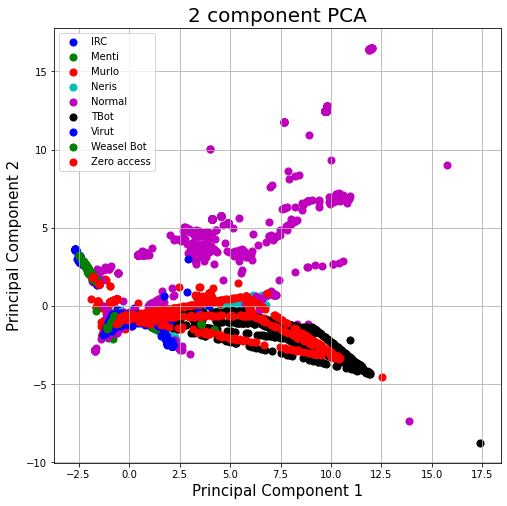

In [36]:
from itertools import cycle

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Neris', 'Normal', 'TBot', 'RBot']
#colors = ['r', 'g', 'b','c']


cycol = cycle('bgrcmk')

    
for target in targets:
    indicesToKeep = principal_df['BotNet_Label'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2']
               , c = next(cycol)
               , s = 50)
ax.legend(targets)
ax.grid()

In [37]:
targets

['IRC',
 'Menti',
 'Murlo',
 'Neris',
 'Normal',
 'TBot',
 'Virut',
 'Weasel Bot',
 'Zero access']

### Use your Favourite Classifier to Make Predictions

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

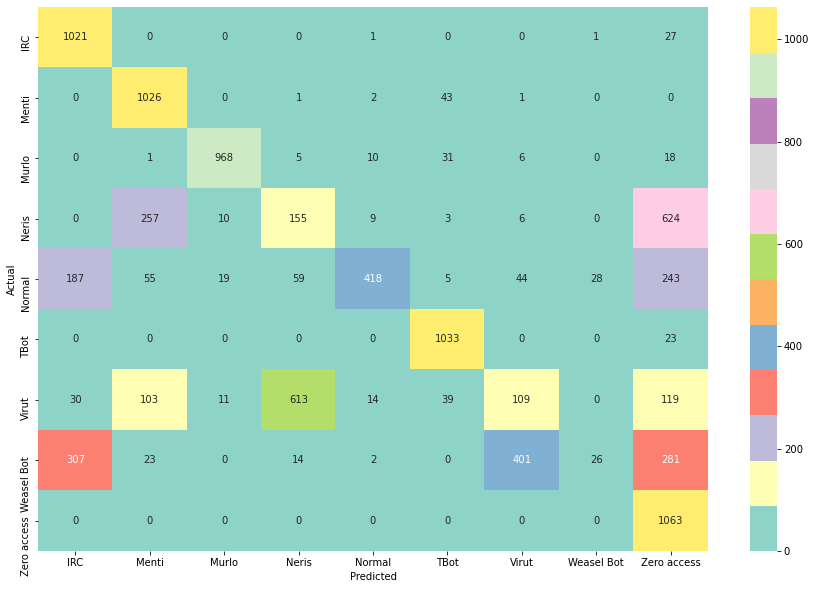

CPU times: user 4.51 s, sys: 10.1 s, total: 14.6 s
Wall time: 14.7 s


In [39]:
%%time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = gnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)


# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [40]:
from sklearn.metrics import accuracy_score

print("Accuracy: " , (accuracy_score(y_test, y_pred)))

Accuracy:  0.6128488678251711


# Well Done!